# ASSIGNMENT_2    : TIME SERIES ANALYSIS                  DATE:05/10/2020

## NAME: Shoraj Tomer : MDS201931


Import the required Libraries and Functions

In [43]:
import warnings                
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy import stats

from sklearn import linear_model
from sklearn.metrics import r2_score
from scipy.stats import kurtosis
from scipy.stats import skew

from statsmodels.compat import lzip
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf

from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.metrics import mean_squared_error

np.random.seed(123)

Load the data Set

DAta set:  For this assignment, i used RBL BANK stoke Price Data set from Date 19-09-2019 to 18-09-2020. There are total of 249 instance  containing Open Price, High price, low price, Close, Adj Close and Volume Price. Here is the link of used data set https://github.com/shoraj1551/TSA-Assignment-1/raw/main/RBLBANK.NS.csv.7z .


Here i have insert the data set from my local machine.

In [2]:
data = pd.read_csv("E:\\M.Sc IN Data Science\\3rd SEMESTER AUG-NOV 2020\\Time Series Analysis\\RBLBANK.NS.csv", sep=",", index_col = 'Date')
data.shape

(249, 6)

Description of Data Set

In [3]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-09-19,350.399994,350.799988,324.450012,332.100006,329.201263,8199527.0
2019-09-20,333.000000,398.399994,325.700012,382.950012,379.607422,23179162.0
2019-09-23,386.799988,415.000000,386.000000,398.350006,394.872986,14154555.0
2019-09-24,403.000000,406.500000,385.200012,401.000000,397.499847,8140651.0
2019-09-25,396.149994,403.600006,377.700012,383.700012,380.350861,8431771.0


For our Analysis we have used Close Price of Daily Data.

In [4]:
df = data['Close']
#print(df)

From the data set we have noted that one value is missing. So we need to fix this problem. Here, we replace the Close Price data by the average of previous and next value.

In [5]:
df = data['Close']
for j in range(len(df)):
    if math.isnan(df[j])== True:
        df[j] = 0.5*(df[j-1]+df[j+1])         
#print(df)

Here we plot this time series data.

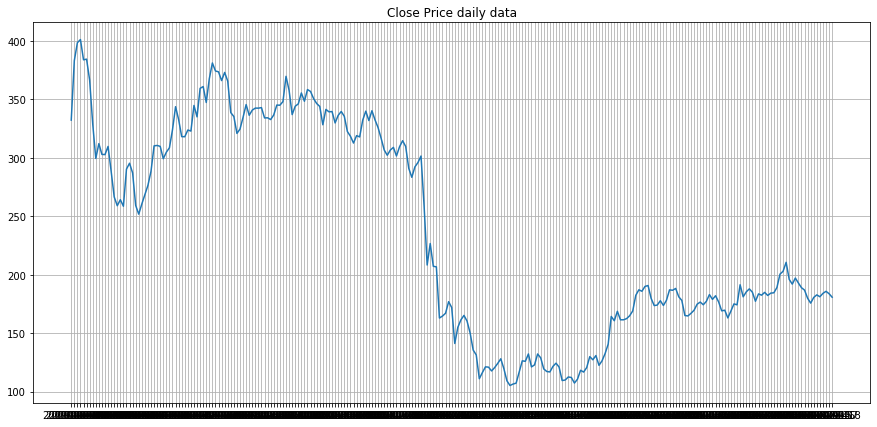

In [6]:
plt.figure(figsize=(15, 7))
plt.plot(df)
plt.title('Close Price daily data')
plt.grid(True)
plt.show()

Lets distribute the Data as Test data and Train Data Set. In train data set we have 237 observations and for test data set we have 11 observations.

In [7]:
train_data = df[:-11]
test_data = df[-11:]

print(train_data)
print(test_data)

Date
2019-09-19    332.100006
2019-09-20    382.950012
2019-09-23    398.350006
2019-09-24    401.000000
2019-09-25    383.700012
2019-09-26    384.250000
2019-09-27    366.250000
2019-09-30    328.850006
2019-10-01    299.350006
2019-10-03    312.000000
2019-10-04    302.799988
2019-10-07    302.649994
2019-10-09    309.600006
2019-10-10    288.500000
2019-10-11    266.450012
2019-10-14    258.899994
2019-10-15    264.049988
2019-10-16    258.450012
2019-10-17    290.200012
2019-10-18    295.250000
2019-10-22    286.950012
2019-10-23    259.149994
2019-10-24    251.699997
2019-10-25    260.350006
2019-10-27    268.375000
2019-10-29    276.399994
2019-10-30    288.450012
2019-10-31    310.100006
2019-11-01    310.450012
2019-11-04    309.649994
                 ...    
2020-07-24    182.899994
2020-07-27    178.800003
2020-07-28    181.899994
2020-07-29    176.649994
2020-07-30    169.000000
2020-07-31    169.550003
2020-08-03    162.949997
2020-08-04    168.800003
2020-08-05    174.94

Here We plot the train and test Data.

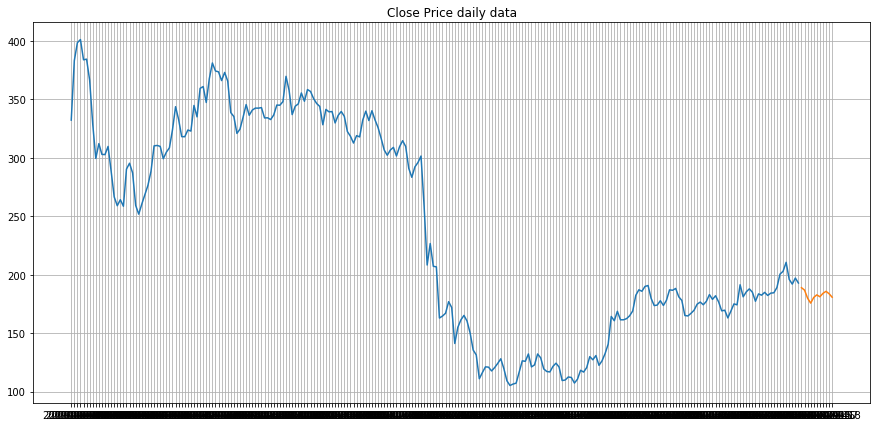

In [8]:
plt.figure(figsize=(15, 7))
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.title('Close Price daily data')
plt.grid(True)
plt.show()

Descriptive Statistics About the train_data Set

In [9]:
train_data.describe()

count    238.000000
mean     239.624685
std       90.313385
min      105.150002
25%      164.850002
50%      207.674995
75%      331.237503
max      401.000000
Name: Close, dtype: float64

In [10]:
k = train_data.kurtosis()
s = train_data.skew()
print(f'Kurtosis: {k}')
print(f'skew: {s}')

Kurtosis: -1.5710656690556282
skew: 0.04226196113120253


We want to check how much Data lies between the interval [ -3*std, 3*std]. For this purpose, let us Define a general function check_data.

In [11]:
def check_data(x):
    sigma = x.std()
    mean = x.mean()
    c = 0 
    for i in range(len(x)):
        if x[i] > (mean -3*sigma) and x[i] < (mean + 3*sigma):
            c = c + 1
    per_data = (c/len(x))*100

    print(f'Percentage of data between mean-3*sigma and mean+3*sigma is : {per_data}')

In [12]:
check_data(train_data)

Percentage of data between mean-3*sigma and mean+3*sigma is : 100.0


# Apply the Stationary Test (ADF, PP and KPSS Test)

ADF TEST

In [13]:
#define function for ADF test
def Adf_test(series):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p_value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    print(f'Result: The series is {"not " if dftest[1] > 0.05 else ""}stationary')

In [14]:
Adf_test(train_data)

Results of Dickey-Fuller Test:
Test Statistic                  -1.181108
p_value                          0.681669
#Lags Used                       0.000000
Number of Observations Used    237.000000
Critical Value (1%)             -3.458247
Critical Value (5%)             -2.873814
Critical Value (10%)            -2.573311
dtype: float64
Result: The series is not stationary


KPSS Test

In [15]:
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

In [16]:
warnings.filterwarnings('ignore')
kpss_test(train_data)

KPSS Statistic: 1.1199084767360703
p-value: 0.01
num lags: 15
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


PP Test

In [19]:
from arch.unitroot import PhillipsPerron
def pp_test(series):    
    pp = PhillipsPerron(series)
    print(pp.summary().as_text())

In [20]:
pp_test(train_data)

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.270
P-value                         0.643
Lags                               15
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


REMARK: As p = 0.643 > 0.05 So, We accept NUll Hypothesis and hence series is not stationary.

From all three test we have the given series is NOT STATIONARY.

Now we need to convert our data as a stationary time series. Since our data is financial data so lets take log return data.

In [21]:
data['log_ret'] = np.log(df) - np.log(df.shift(1))

In [22]:
r_t = data['log_ret']
#print(r_t)

Here we drop all NaN Value.

In [23]:
r_t = r_t.dropna()
#print(r_t)

Lets plot the log return data with respect to time

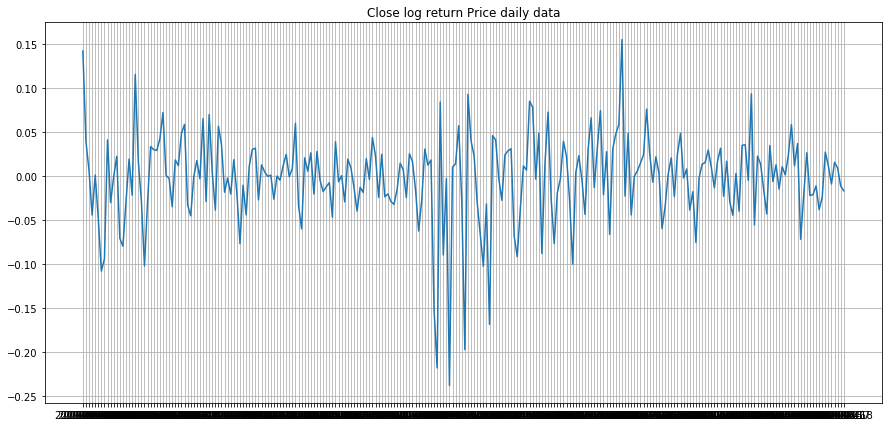

In [24]:
plt.figure(figsize=(15, 7))
plt.plot(r_t)
plt.title('Close log return Price daily data')
plt.grid(True)
plt.show()

Break the data into test and training data

In [25]:
logtrain_data = r_t[:-11]
logtest_data = r_t[-11:]
print(logtrain_data)
print(logtest_data)

Date
2019-09-20    0.142468
2019-09-23    0.039427
2019-09-24    0.006630
2019-09-25   -0.044100
2019-09-26    0.001432
2019-09-27   -0.047977
2019-09-30   -0.107714
2019-10-01   -0.093988
2019-10-03    0.041390
2019-10-04   -0.029931
2019-10-07   -0.000495
2019-10-09    0.022704
2019-10-10   -0.070586
2019-10-11   -0.079508
2019-10-14   -0.028745
2019-10-15    0.019697
2019-10-16   -0.021436
2019-10-17    0.115868
2019-10-18    0.017252
2019-10-22   -0.028514
2019-10-23   -0.101901
2019-10-24   -0.029169
2019-10-25    0.033789
2019-10-27    0.030358
2019-10-29    0.029464
2019-10-30    0.042673
2019-10-31    0.072373
2019-11-01    0.001128
2019-11-04   -0.002580
2019-11-05   -0.034665
                ...   
2020-07-24    0.031943
2020-07-27   -0.022672
2020-07-28    0.017189
2020-07-29   -0.029287
2020-07-30   -0.044272
2020-07-31    0.003249
2020-08-03   -0.039704
2020-08-04    0.035271
2020-08-05    0.035786
2020-08-06   -0.004583
2020-08-07    0.093926
2020-08-10   -0.055346
2020-0

Plot the logtrain_data and logtest_data

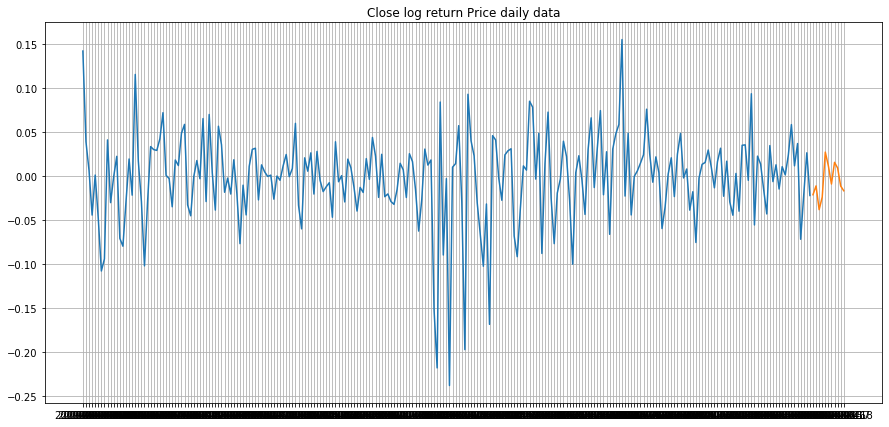

In [26]:
plt.figure(figsize=(15, 7))
plt.plot(logtrain_data.index, logtrain_data)
plt.plot(logtest_data.index, logtest_data)
plt.title('Close log return Price daily data')
plt.grid(True)
plt.show()

Description of logtrain_data

In [27]:
logtrain_data.describe()

count    237.000000
mean      -0.002294
std        0.050565
min       -0.237955
25%       -0.026826
50%        0.001432
75%        0.025311
max        0.155522
Name: log_ret, dtype: float64

In [28]:
k = logtrain_data.kurtosis()
s = logtrain_data.skew()
print(k)
print(s)

4.213853992599857
-1.0417936283736156


In [29]:
check_data(logtrain_data)

Percentage of data between mean-3*sigma and mean+3*sigma is : 97.8902953586498


Check Stationarity of log return data 

In [30]:
Adf_test(logtrain_data)

Results of Dickey-Fuller Test:
Test Statistic                  -3.917358
p_value                          0.001911
#Lags Used                       8.000000
Number of Observations Used    228.000000
Critical Value (1%)             -3.459361
Critical Value (5%)             -2.874302
Critical Value (10%)            -2.573571
dtype: float64
Result: The series is stationary


In [31]:
kpss_test(logtrain_data)

KPSS Statistic: 0.14579672259685258
p-value: 0.1
num lags: 15
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


In [32]:
pp_test(logtrain_data)

     Phillips-Perron Test (Z-tau)    
Test Statistic                -14.407
P-value                         0.000
Lags                               15
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


REMARK: As p = 0.000 < 0.05 So, We reject NUll Hypothesis and hence series is Weekly stationary.

# Now We apply the ARIMA model

In [33]:
from statsmodels.tsa.arima_model import ARIMA

Apply AIC and BIC criterion to find out values of p and q 

In [38]:
def par_sel (m,n):
    AB = {}
    for p in range(m):
        for q in range(n):
            try:
                mod = ARIMA(logtrain_data, order= (p,0,q))
                result = mod.fit()
                AB[(p,q)] = [result.aic, result.bic]
            except:
                continue
    return AB

In [39]:
par_sel(5,5)

{(0, 0): [-739.0720290703279, -732.1359087880576],
 (0, 1): [-738.8478255739362, -728.4436451505309],
 (0, 2): [-737.0447771125891, -723.1725365480486],
 (0, 3): [-738.8378914087168, -721.4975907030412],
 (0, 4): [-737.0049140033309, -716.1965531565202],
 (1, 0): [-738.8951343906585, -728.4909539672532],
 (1, 1): [-736.8951915952907, -723.0229510307502],
 (2, 0): [-736.8953465548948, -723.0231059903542],
 (2, 1): [-735.2732328763288, -717.9329321706532],
 (3, 0): [-738.2396255471331, -720.8993248414574],
 (3, 1): [-736.268113574869, -715.4597527280582],
 (3, 2): [-742.4471635226989, -718.170742534753],
 (3, 3): [-735.5883259171144, -707.8438447880334],
 (4, 0): [-736.3159718562267, -715.507611009416],
 (4, 1): [-736.5808655543512, -712.3044445664053],
 (4, 2): [-741.3308667217184, -713.5863855926374],
 (4, 3): [-728.5958552389445, -697.3833139687283]}

Remark: So We select p = 3 and q = 2

Fit ARMA model

In [40]:
p = 3
q = 2
mod = ARIMA(logtrain_data, order =(p,0,q))
result = mod.fit()
print(result.aic)

# Compare AIC and BIC value for p = 3 and q = 2
print(result.aic, result.bic)

-742.4471635226989
-742.4471635226989 -718.170742534753


In [53]:
history = [x for x in logtrain_data]
predictions = list()
for t in range(len(logtest_data)):
    model= ARIMA(history, order=(3,0,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = logtest_data[t]
    history.append(obs)

    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test_data, predictions)
print('Test MSE: %.3f' % error)

predicted=0.002213, expected=-0.020965
predicted=-0.009630, expected=-0.010917
predicted=-0.007908, expected=-0.037926
predicted=0.000345, expected=-0.023636
predicted=0.001278, expected=0.027522
predicted=-0.001731, expected=0.011841
predicted=-0.004997, expected=-0.008798
predicted=-0.004098, expected=0.015891
predicted=0.001565, expected=0.009468
predicted=0.000575, expected=-0.011101
predicted=-0.006512, expected=-0.016470
Test MSE: 33372.649


Now, we convert log return to original price value

In [55]:
fin_pred = [train_data[-1]]
for i in range(len(test_data)):
    x = fin_pred[-1]
    y = predictions[i]
    fin_pred.append(x*math.exp(y))
fin_pred = fin_pred[1:]

In [58]:
for j in range(len(fin_pred)):
    print(fin_pred[j],":", test_data[j])
error = mean_squared_error(fin_pred, test_data)
print('Test MSE: %.3f' % error)

193.2272156157813 : 188.800003
191.3753639870883 : 186.75
189.86788110089722 : 179.800003
189.9334357802672 : 175.600006
190.17628347315363 : 180.5
189.8473660280594 : 182.649994
188.90108662575253 : 181.050003
188.12849946764103 : 183.949997
188.42312421158704 : 185.699997
188.5314557376391 : 183.649994
187.30772482582523 : 180.649994
Test MSE: 58.900


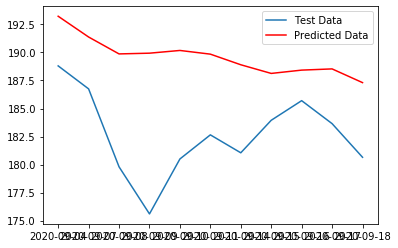

In [60]:
plt.plot(test_data)
plt.plot(fin_pred, color='red')
plt.legend(('Test Data', 'Predicted Data'))
plt.show()